# Determinando la mejor agrupación de las tiendas de Starbucks según su ubicación geográfica



## 1. Descripción del problema 

Se desea conocer cuál es la mejor forma de agrupar las tiendas de Starbucks, a nivel mundial, según su ubicación geográfica. Con esta información, se puede decidir cómo estructurar los cargos administrativos de la empresa; por ejemplo, algunas compañías toman Centroamérica como una región, mientras que otras tienen operaciones específicas para Costa Rica. 

Para esto, se utilizarán técnicas de aprendizaje no supervisado, específicamente de *clustering*, pues no se conoce con antelación cuál es el mejor agrupamiento de las tiendas. En este contexto, el *mejor agrupamiento* no necesariamente será el óptimo, sino que se refiere al *mejor agrupamiento obtenido por algún algoritmo* pues, como en diversos problemas de aprendizaje no supervisado, no se conoce cuál es la solución óptima al problema.

## 2. Preprocesamiento y limpieza de datos

El preprocesamiento y limpieza de datos se llevó a cabo con **Open Refine**. Se adjunta en el repositorio el historial de acciones realizadas.

### 2.a Eliminar columnas redundantes o que no se utilizarán

Las columnas redundantes son aquellas que poseen poca variabilidad, es decir, que poseen el mismo valor en una gran mayoría de las entradas. En este *dataset*, las columnas **Brand** y **Ownership Type** tienen muy poca variabilidad, pues casi la totalidad de las filas tienen los valores *Starbucks* y *Licensed*, respectivamente. Por esta razón, se eliminan del *dataset*.

Adicionalmente, se eliminan las columnas que no se utilizarán en el trabajo. Específicamente:

- **Store Number**
- **Store Name**
- **Street Address**
- **City**
- **State/Province**
- **Postcode**
- **Phone Number**

Esta limpieza se realizara para disminuir el ruido que entrará al modelo, una vez se inicie con el aprendizaje no supervisado.

### 2.b Cambiar tipo de datos en columnas de Longitud y Latitud

Algunos valores en estas columnas son de tipo entero, mientras que la mayoría son de tipo *double*. Para corregir estas inconsistencias, se convertirán todos los valores en la columna a tipo *double*. Esto es necesario puesto que, en algunas ocasiones, los modelos no reconocen estas diferencias en los tipos, por lo que no pueden ejecutarse correctamete.

## 3. Transformación de datos

La transformación de datos se llevó a cabo con **Open Refine**. Se adjunta en el repositorio el historial de acciones realizadas.

### 3.a Transformación de la columna Timezone 

En el *dataset* original, esta columna indica la zona horaria, continente y país de ubicación de la tienda. Se aplicó una transformación para que, únicamente, muestre el continente. De esta forma, si el valor original era

> GMT+1:00 Europe/Andorra ,

se transforma a

> Europe.

Esta transformación se llevó a cabo con el siguiente código GREL:

```
if(contains(value, "Africa"),1,if(contains(value, "America"),2,if(contains(value, "Asia"),3,if(contains(value, "Europe"),4,5))))
```

### 3.b Creación de columna isUnitedStates a partir de Country

Se incluyó una nueva columna con valores booleanos, llamada *isUnitedStates*, creada a partir de la columna *Country*.

Esta transformación se llevó a cabo con el siguiente código GREL:

```
if(value == "US", 1,0)
```


Ambas transformaciones se llevaron a cabo para ser utilizadas en la siguiente sección, Análisis Exploratorio de Datos, donde se lleva a cabo un estudio según las clases (es decir, ubicación) a la que pertenecen las tiendas.

## 4. Análisis Exploratorio de Datos

In [1]:
from google.colab import files
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np 
from numpy import unique
from numpy import where
from scipy.stats import pearsonr
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot
import pandas as pd

uploaded = files.upload()
data = pd.read_csv('Starbucks.csv')

Saving Starbucks.csv to Starbucks.csv


### 4.a Estadística Descriptiva

Primeramente, se observa cómo luce el conjunto de datos una vez limpiado:

In [2]:
data.head()

,isUnitedStates,Continent,Longitude,Latitude
0,0,4,1.53,42.51
1,0,3,55.47,25.42
2,0,3,55.47,25.39
3,0,3,54.38,24.48
4,0,3,54.54,24.51


Luego, se pueden obtener las principales medidas estadísticas para cada atributo en los datos:

In [3]:
data.describe()

,isUnitedStates,Continent,Longitude,Latitude
count,25599.000000,25599.000000,25599.000000,25599.000000
mean,0.531583,2.458221,-27.872234,34.793016
std,0.499011,0.663441,96.844046,13.342332
min,0.000000,1.000000,-159.460000,-46.410000
25%,0.000000,2.000000,-104.665000,31.240000
50%,1.000000,2.000000,-79.350000,36.750000
75%,1.000000,3.000000,100.630000,41.570000
max,1.000000,5.000000,176.920000,64.850000


Seguidamente, se realizan distintos gráficos para obtener una impresión visual de la composición de los datos.

#### 4.a.1 Histograma para Continent



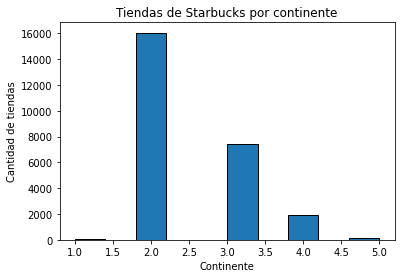

In [29]:
plt.title('Tiendas de Starbucks por continente')
plt.xlabel('Continente')
plt.ylabel('Cantidad de tiendas')
plt.hist(data['Continent'], edgecolor="k")
plt.show()

#### 4.a.2 Histograma para isUnitedStates

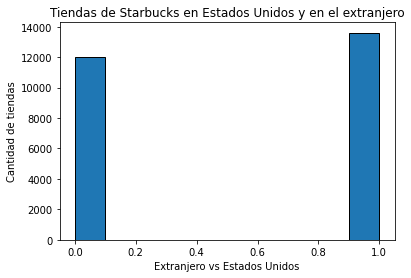

In [31]:
plt.title('Tiendas de Starbucks en Estados Unidos y en el extranjero')
plt.xlabel('Extranjero vs Estados Unidos')
plt.ylabel('Cantidad de tiendas')
plt.hist(data['isUnitedStates'], edgecolor="k")
plt.show()

#### 4.a.3 Diagrama de cajas para Longitud

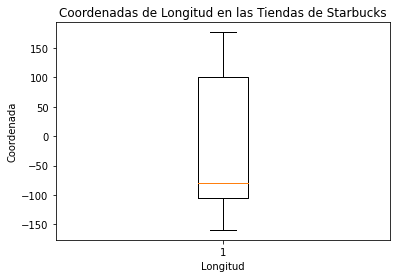

In [34]:
plt.title('Coordenadas de Longitud en las Tiendas de Starbucks')
plt.xlabel('Longitud')
plt.ylabel('Coordenada')
plt.boxplot(data['Longitude'])
plt.show()

#### 4.a.4 Diagrama de cajas para Latitud

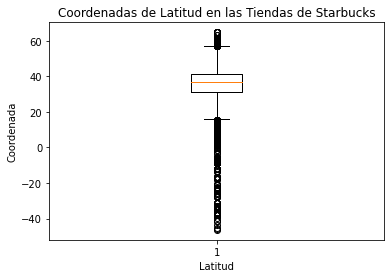

In [35]:
plt.title('Coordenadas de Latitud en las Tiendas de Starbucks')
plt.xlabel('Latitud')
plt.ylabel('Coordenada')
plt.boxplot(data['Latitude'])
plt.show()

### 4.b Particionamiento en clases

Puesto que Starbucks es una compañía estadounidense, se espera que la mayoría de sus tiendas se encuentren en los Estados Unidos. Por ende, al confirmar esta suposición con la información proveniente de los datos, se agruparán en dos clases: las tienas que pertenecen a los Estados Unidos y las que no. Con esto, se pueden tener impresiones sobre sus coordenadas geográficas, una vez separadas en estos dos tipos.

En línea con el objetivo de la investigación, es común que las empresas administren sus cargos ejecutivos de una manera distinta según se trate de tiendas locales o en el extranjero. Por ende, es natural la separación entre tiendas ubicadas en el país de procedencia y aquellas ubicadas en otros países.

In [41]:
dataUS = data[(data["isUnitedStates"] == 1)]
dataOtherCountries = data[(data["isUnitedStates"] == 0)]
print("Observaciones totales = ", len(data))
print("Observaciones de Estados Unidos = ", len(dataUS))
print("Observaciones de otros paises = ", len(dataOtherCountries))

Observaciones totales =  25599
Observaciones de Estados Unidos =  13608
Observaciones de otros paises =  11991


#### 4.b.1 Diagrama de cajas para columna Longitud de tiendas en Estados Unidos

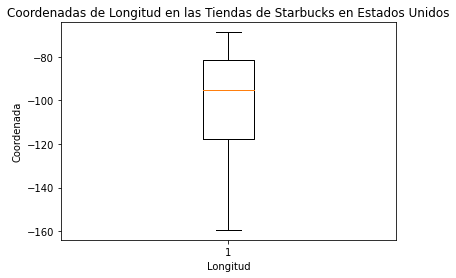

In [42]:
plt.title('Coordenadas de Longitud en las Tiendas de Starbucks en Estados Unidos')
plt.xlabel('Longitud')
plt.ylabel('Coordenada')
plt.boxplot(dataUS['Longitude'])
plt.show()

#### 4.b.2 Diagrama de cajas para columna Latitud de tiendas en Estados Unidos

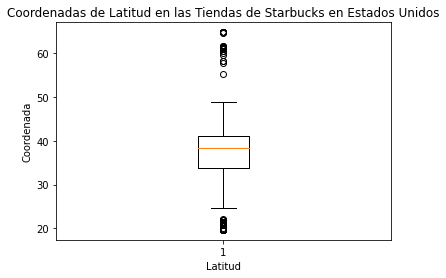

In [43]:
plt.title('Coordenadas de Latitud en las Tiendas de Starbucks en Estados Unidos')
plt.xlabel('Latitud')
plt.ylabel('Coordenada')
plt.boxplot(dataUS['Latitude'])
plt.show()

#### 4.b.3 Diagrama de cajas para columna Longitud de tiendas fuera de Estados Unidos

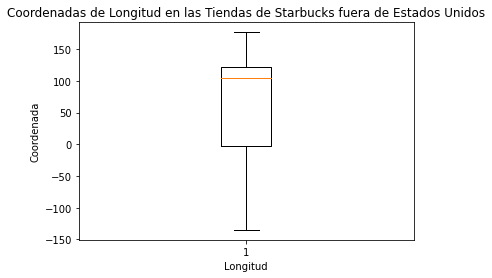

In [45]:
plt.title('Coordenadas de Longitud en las Tiendas de Starbucks fuera de Estados Unidos')
plt.xlabel('Longitud')
plt.ylabel('Coordenada')
plt.boxplot(dataOtherCountries['Longitude'])
plt.show()

#### 4.b.4 Diagrama de cajas para columna Latitud de tiendas fuera de Estados Unidos

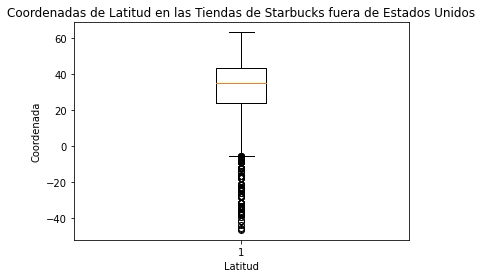

In [44]:
plt.title('Coordenadas de Latitud en las Tiendas de Starbucks fuera de Estados Unidos')
plt.xlabel('Latitud')
plt.ylabel('Coordenada')
plt.boxplot(dataOtherCountries['Latitude'])
plt.show()

Con las observaciones anteriores, se pudo obtener una impresión gráfica de cómo están compuestos los datos. Primero, se puede concluir que la cantidad de tiendas en Estados Unidos es mayor que la totalidad de las tiendas de Starbucks en el resto del mundo; esto confirma que, al estructurar los cargos administrativos de la compañía, se debe tener especial atención en el caso de Estados Unidos, pues contiene muchas más tiendas que cualquier otro país.

También, al realizar la separación por clases, se puede ver cómo se redujeron los valores tanto de longitud y latitud en el caso de los datos que únicamente toman en cuenta a Estados Unidos. Esto corresponde con los datos del mundo real, pues ese país se encuentra al oeste del meridiano Greenwich y al norte del Ecuador, por lo que su longitud y latitud serán, respectivamente, negativas y positivas.

## 5. Técnicas de segmentación

Explicar por qué sirven

### 5.a K-Means

### 5.b DBSCAN

## 6. Evaluación de modelos

### 6.a Silhouette Analysis - K-Means

### 6.b Silhouette Analysis - DBSCAN

## 7. Resultados

Gráfica + tabla

## 8. Análisis